In [24]:
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

In [25]:
dataset = load_iris()
X = dataset.data
y = dataset.target
print(f"Shape of features x datapoints: {X.shape}")
print(f"Example of input:{X[0,:]}")
print(f"Shape of labels {y.shape}")
print(f"Example of output:{y[0]}")
print(f"Len of output:{len(np.unique(y))}")
unique_labels = np.unique(y)
for i in range(len(unique_labels)):
    print(f"{i}: {unique_labels[i]}")


Shape of features x datapoints: (150, 4)
Example of input:[5.1 3.5 1.4 0.2]
Shape of labels (150,)
Example of output:0
Len of output:3
0: 0
1: 1
2: 2


One hot encoding for output

In [26]:
def one_hot_encoding(categorical_value):
    no_of_classes = len(np.unique(categorical_value))
    return np.eye(no_of_classes)[categorical_value]

In [27]:
Y = one_hot_encoding(y)
print(f"Shape of labels {Y.shape}")
print(f"Example of output:{Y[0]}")
print(f"Len of output:{len(np.unique(Y))}")

Shape of labels (150, 3)
Example of output:[1. 0. 0.]
Len of output:2


we must add a 1 to every input vector to include bias in weights


In [28]:
def extend_input_with_bias(network_input):
    bias_extension = np.ones(network_input.shape[1]).reshape(1,-1)
    network_input = np.vstack([bias_extension, network_input])
    return network_input

Transpose input and output

In [29]:
X = X.T
Y = Y.T
print(f"Shape of features x datapoints: {X.shape}")
print(f"Example of input:{X[:,0]}")
print(f"Shape of labels {Y.shape}")
print(f"Example of output:{Y[:,0]}")

Shape of features x datapoints: (4, 150)
Example of input:[5.1 3.5 1.4 0.2]
Shape of labels (3, 150)
Example of output:[1. 0. 0.]


In [30]:
def describe_data(data): # describe -> returns a String
    return f"number of neurons is: {data.shape[0]} and number of datapoints is {data.shape[1]}"
print(f"For input {describe_data(X)}")
print(f"For output {describe_data(Y)}")
    

For input number of neurons is: 4 and number of datapoints is 150
For output number of neurons is: 3 and number of datapoints is 150


## creating neural network with imp of forward propagation
just means starting at input and finishing at output

In [31]:
def create_network(input_size, output_size, hidden_sizes):
    network = []  # just a list of hidden layers
    layer_size = hidden_sizes
    layer_size.append(output_size)
    for neuron_count in layer_size:
        layer = np.random.rand(input_size +1, neuron_count)*2-1 # it only returns values from 0 to 1, thats why multiplying- and allowing negative values appearing by substracting 1 so [-1,1] range
        input_size = neuron_count
        network.append(layer)
    return network
def describe_layer(layer):
    return f"there is {layer.shape[1]} neurons is and {layer.shape[0]} features in inputs"

In [32]:
network = create_network(X.shape[0], Y.shape[0], [7,6])
for idx, layer in enumerate(network):
    print(f"In layer {idx},{describe_layer(layer)}")

In layer 0,there is 7 neurons is and 5 features in inputs
In layer 1,there is 6 neurons is and 8 features in inputs
In layer 2,there is 3 neurons is and 7 features in inputs


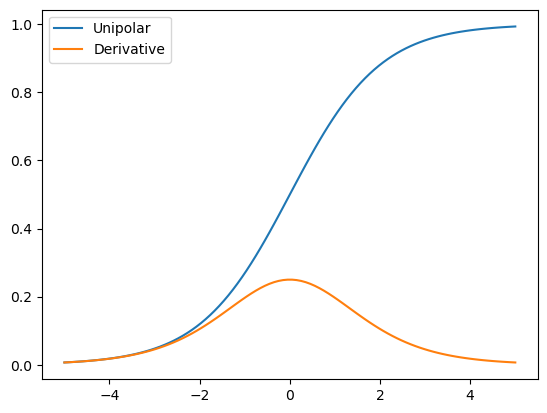

In [33]:
def unipolar_activation(u):
    return 1 / (1 + np.exp(-u))
def unipolar_derivative(d):
    d = unipolar_activation(d)
    return d*(1-d)
demo_x = np.linspace(-5, 5, 100)
demo_y = unipolar_activation(demo_x)
demo_derivative = unipolar_derivative(demo_x)
plt.plot(demo_x, demo_y, label = 'Unipolar')
plt.plot(demo_x, demo_derivative, label = 'Derivative')
plt.legend()
plt.show()

In [34]:
def feed_forward(network_input, network):
    layer_input = network_input
    responses = []
    for weights in network:
        layer_input = extend_input_with_bias(layer_input)
        response = unipolar_activation(weights.T @ layer_input)
        layer_input = response
        responses.append(response)
    return responses

def predict(network_input, network):
    return feed_forward(network_input, network)[-1]

def calculate_mse(predicted, expected):
    return np.sum((predicted-expected)**2)/len(predicted)
    

In [35]:
Y_predicted = predict(X, network)
print(f"MSE = {calculate_mse(Y_predicted, Y)}")

MSE = 41.09259080671898


In [36]:
responses = feed_forward(X, network)
for idx, response in enumerate(responses):
    print(f"for response of {idx} layer {describe_data(response)}")

for response of 0 layer number of neurons is: 7 and number of datapoints is 150
for response of 1 layer number of neurons is: 6 and number of datapoints is 150
for response of 2 layer number of neurons is: 3 and number of datapoints is 150


In [37]:
print(np.argmax(Y_predicted, axis = 0))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


### Implementing backpropagation
First we compute and backpropagate - where the value will be calculated and weights changed


In [38]:
def backpropagate(network, responses, expected_output_layer_response):
    gradients = []
    error = responses[-1] - expected_output_layer_response
    for weights, response in zip(reversed(network), reversed(responses)):
        gradient = error*unipolar_derivative(response)
        gradients.append(gradient)
        error = weights @ gradient
        error = error[1:,:]
    return list(reversed(gradients))

In [39]:
gradients = backpropagate(network, responses, Y)
for idx, gradient in enumerate(gradients):
    print(f"For gradient of {idx} layer {describe_data(gradient)}")

For gradient of 0 layer number of neurons is: 7 and number of datapoints is 150
For gradient of 1 layer number of neurons is: 6 and number of datapoints is 150
For gradient of 2 layer number of neurons is: 3 and number of datapoints is 150


In [40]:
def calculate_weights_changes(network, network_input, network_respones, gradients, learning_factor):
    layer_inputs = [network_input] + network_respones[:-1]
    weights_changes =[]
    for weights, layer_input, gradient in zip(network, layer_inputs, gradients):
        layer_input = extend_input_with_bias(layer_input)
        print(layer_input)
        change = layer_input.dot(gradient.T)*learning_factor
        weights_changes.append(change)
    return weights_changes

In [41]:
changes = calculate_weights_changes(network, X, responses,gradients, 0.3)
for idx, change in enumerate(changes):
    print(f"for change of {idx} layer {describe_layer(change)}")

[[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. ]
 [5.1 4.9 4.7 4.6 5.  5.4 4.6 5.  4.4 4.9 5.4 4.8 4.8 4.3 5.8 5.7 5.4 5.1
  5.7 5.1 5.4 5.1 4.6 5.1 4.8 5.  5.  5.2 5.2 4.7 4.8 5.4 5.2 5.5 4.9 5.
  5.5 4.9 4.4 5.1 5.  4.5 4.4 5.  5.1 4.8 5.1 4.6 5.3 5.  7.  6.4 6.9 5.5
  6.5 5.7 6.3 4.9 6.6 5.2 5.  5.9 6.  6.1 5.6 6.7 5.6 5.8 6.2 5.6 5.9 6.1
  6.3 6.1 6.4 6.6 6.8 6.7 6.  5.7 5.5 5.5 5.8 6.  5.4 6.  6.7 6.3 5.6 5.5
  5.5 6.1 5.8 5.  5.

In [42]:
def adjust_weigths(network, changes):
    new_network = []
    for weights, changes in zip(network, changes):
        new_weights = weights - changes
        new_network.append(new_weights)
    return new_network

In [43]:
network = adjust_weigths(network, changes)
for idx, layer in enumerate(network):
    print(f"In layer {idx},{describe_layer(layer)}")
Y_predicted = predict(X, network)
print(f"MSE = {calculate_mse(Y_predicted, Y)}")    
    

In layer 0,there is 7 neurons is and 5 features in inputs
In layer 1,there is 6 neurons is and 8 features in inputs
In layer 2,there is 3 neurons is and 7 features in inputs
MSE = 47.30690350950321


In [44]:
def train_network(network, network_input, expected_output, learning_factor, epochs):
    mse_history = []
    for _ in range(epochs):
        responses = feed_forward(network_input, network)
        mse_history.append(calculate_mse(responses[-1], expected_output))
        gradients = backpropagate(network, responses, Y)
        changes = calculate_weights_changes(network, network_input, responses, gradients, learning_factor)
        network = adjust_weigths(network, changes)
    mse_history.append(calculate_mse(responses[-1], expected_output))
    return network, np.asarray(mse_history)
    

[[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. ]
 [5.1 4.9 4.7 4.6 5.  5.4 4.6 5.  4.4 4.9 5.4 4.8 4.8 4.3 5.8 5.7 5.4 5.1
  5.7 5.1 5.4 5.1 4.6 5.1 4.8 5.  5.  5.2 5.2 4.7 4.8 5.4 5.2 5.5 4.9 5.
  5.5 4.9 4.4 5.1 5.  4.5 4.4 5.  5.1 4.8 5.1 4.6 5.3 5.  7.  6.4 6.9 5.5
  6.5 5.7 6.3 4.9 6.6 5.2 5.  5.9 6.  6.1 5.6 6.7 5.6 5.8 6.2 5.6 5.9 6.1
  6.3 6.1 6.4 6.6 6.8 6.7 6.  5.7 5.5 5.5 5.8 6.  5.4 6.  6.7 6.3 5.6 5.5
  5.5 6.1 5.8 5.  5.

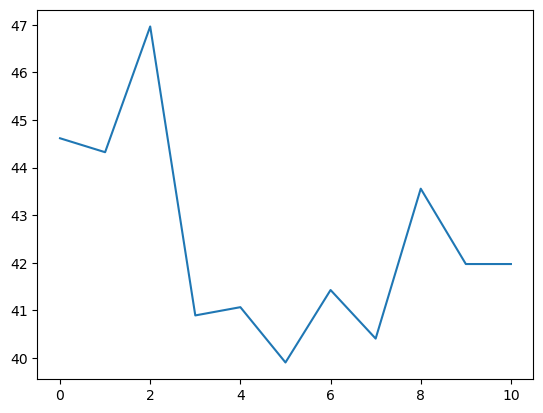

In [45]:
network = create_network(X.shape[0], Y.shape[0], [7,6])
network, mse_history = train_network(network, X, Y, 0.3, 10)
plt.plot(mse_history)

[[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. ]
 [5.1 4.9 4.7 4.6 5.  5.4 4.6 5.  4.4 4.9 5.4 4.8 4.8 4.3 5.8 5.7 5.4 5.1
  5.7 5.1 5.4 5.1 4.6 5.1 4.8 5.  5.  5.2 5.2 4.7 4.8 5.4 5.2 5.5 4.9 5.
  5.5 4.9 4.4 5.1 5.  4.5 4.4 5.  5.1 4.8 5.1 4.6 5.3 5.  7.  6.4 6.9 5.5
  6.5 5.7 6.3 4.9 6.6 5.2 5.  5.9 6.  6.1 5.6 6.7 5.6 5.8 6.2 5.6 5.9 6.1
  6.3 6.1 6.4 6.6 6.8 6.7 6.  5.7 5.5 5.5 5.8 6.  5.4 6.  6.7 6.3 5.6 5.5
  5.5 6.1 5.8 5.  5.

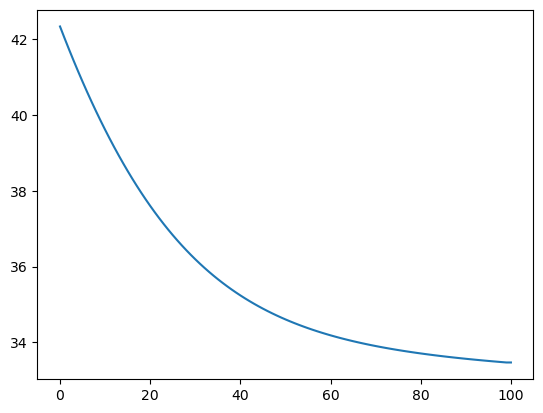

In [46]:
network = create_network(X.shape[0], Y.shape[0], [7,6])
network, mse_history = train_network(network, X, Y, 0.001, 100)
plt.plot(mse_history)